Fetching data from website...
Parsing HTML content...
Successfully scraped data for 234 countries
Processing data...
Converting numerical columns...
   # Country_(or_dependency)  Population_2024  Yearly_Change  Net_Change  \
0  1                   India       1450935791           0.89    12866195   
1  2                   China       1419321278          -0.23    -3263655   
2  3           United States        345426571           0.57     1949236   
3  4               Indonesia        283487931           0.82     2297864   
4  5                Pakistan        251269164           1.52     3764669   

   Density  Land_Area  Migrants  Fert_Rate  Med_Age  Urban_Pop  World_Share  
0      488    2973190   -630830        2.0       28       37.0        17.78  
1      151    9388211   -318992        1.0       40       66.0        17.39  
2       38    9147420   1286132        1.6       38       82.0         4.23  
3      156    1811570    -38469        2.1       30       59.0         3.47  
4   

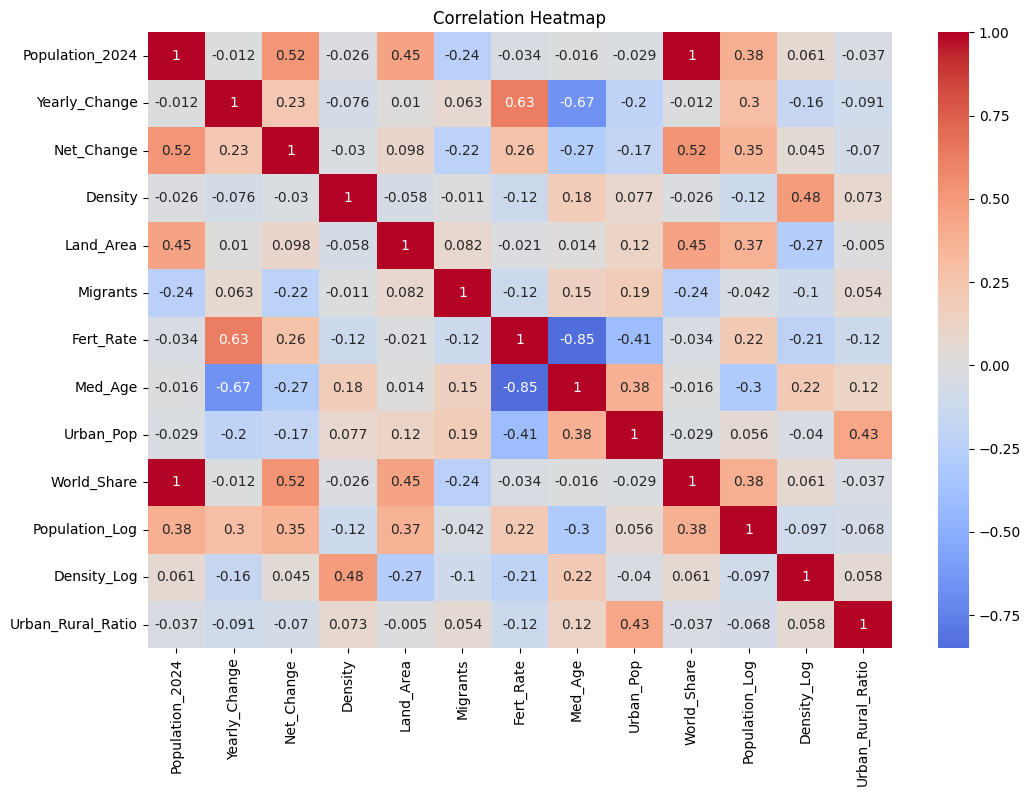

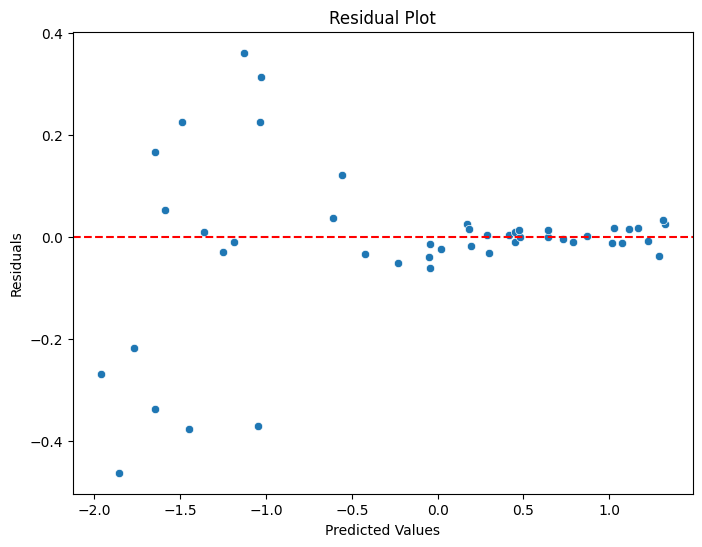

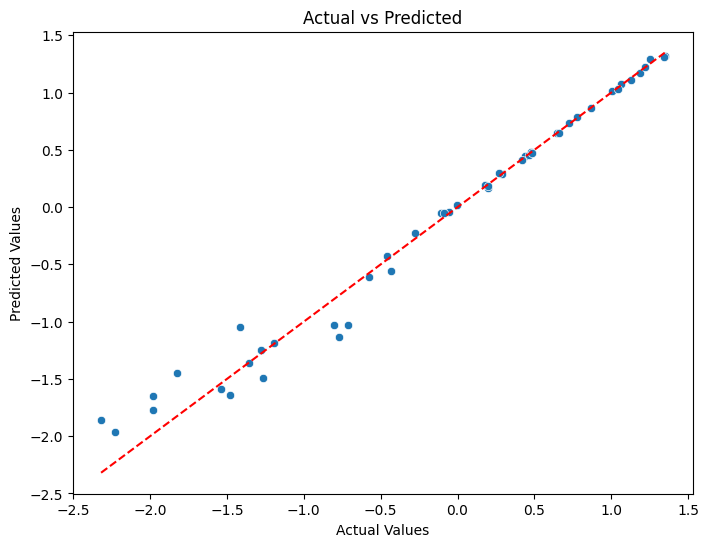

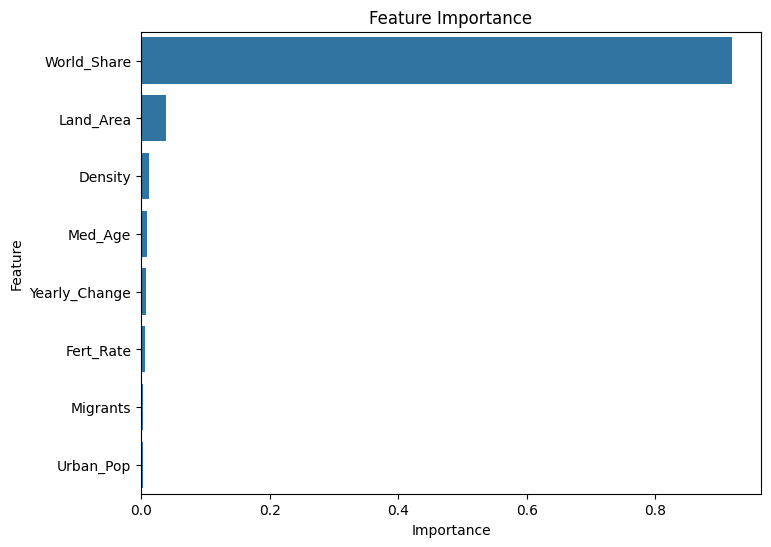

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

class WorldPopulationAnalyzer:
    def __init__(self):
        self.data = None
        self.processed_data = None
        self.model = None
        self.scaler = StandardScaler()

    def scrape_data(self):
        """
        Scrape world population data from the website
        """
        try:
            url = "https://www.worldometers.info/world-population/population-by-country/"
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
            }

            print("Fetching data from website...")
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Raise an error for bad status codes

            print("Parsing HTML content...")
            soup = BeautifulSoup(response.content, 'html.parser')
            table = soup.find('table', {'id': 'example2'})

            if not table:
                raise ValueError("Could not find the data table on the webpage")

            # Initialize lists to store data
            data = []

            # Get headers
            headers = []
            for th in table.find('thead').find_all('th'):
                headers.append(th.text.strip())

            # Get rows
            for row in table.find('tbody').find_all('tr'):
                row_data = {}
                cells = row.find_all('td')

                for i, cell in enumerate(cells):
                    # Clean and store the cell data
                    value = cell.text.strip()
                    # Remove commas from numbers and convert numerical values
                    if ',' in value and value.replace(',', '').replace('.', '').replace('-', '').isdigit():
                        value = value.replace(',', '')
                    row_data[headers[i]] = value

                data.append(row_data)

            # Convert to DataFrame
            self.data = pd.DataFrame(data)
            print(f"Successfully scraped data for {len(self.data)} countries")

            # Clean column names
            self.data.columns = self.data.columns.str.strip().str.replace(' ', '_')

            return self.data

        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            return None
        except Exception as e:
            print(f"Error processing data: {e}")
            return None

    def preprocess_data(self):
        """
        Preprocess the scraped data
        """
        if self.data is None:
            print("No data to process. Please scrape data first.")
            return None

        print("Processing data...")
        self.processed_data = self.data.copy()

        # Convert numerical columns
        print("Converting numerical columns...")

        self.processed_data.rename(columns={
            'Population_(2024)': 'Population_2024',
            'Med._Age': 'Med_Age',
            'Density_(P/Km²)': 'Density',
            'Land_Area_(Km²)': 'Land_Area',
            'Migrants_(net)' : 'Migrants',
            'Fert._Rate': 'Fert_Rate',
            'Urban_Pop_%': 'Urban_Pop'
        }, inplace=True)

        try:
            # Population
            self.processed_data['Population_2024'] = pd.to_numeric(self.processed_data['Population_2024'], errors='coerce')

            # Yearly Change
            self.processed_data['Yearly_Change'] = self.processed_data['Yearly_Change'].str.rstrip('%').astype(float)

            # Net Change
            self.processed_data['Net_Change'] = pd.to_numeric(self.processed_data['Net_Change'], errors='coerce')

            # Density
            self.processed_data['Density'] = pd.to_numeric(self.processed_data['Density'], errors='coerce')

            # Land Area
            self.processed_data['Land_Area'] = pd.to_numeric(self.processed_data['Land_Area'], errors='coerce')

            # Migrants
            self.processed_data['Migrants'] = pd.to_numeric(self.processed_data['Migrants'], errors='coerce')

            # Fertility Rate
            self.processed_data['Fert_Rate'] = pd.to_numeric(self.processed_data['Fert_Rate'], errors='coerce')

            # Median Age
            self.processed_data['Med_Age'] = pd.to_numeric(self.processed_data['Med_Age'], errors='coerce')

            # Urban Population
            # Replace 'N.A.' with NaN
            self.processed_data['Urban_Pop'] = self.processed_data['Urban_Pop'].replace('N.A.', pd.NA)

            # Remove the '%' sign, then convert to float
            self.processed_data['Urban_Pop'] = self.processed_data['Urban_Pop'].str.rstrip('%')

            # Now, safely convert the 'Urban_Pop' column to float, coercing errors to NaN
            self.processed_data['Urban_Pop'] = pd.to_numeric(self.processed_data['Urban_Pop'], errors='coerce')

            # World Share
            self.processed_data['World_Share'] = self.processed_data['World_Share'].str.rstrip('%').astype(float)

        except Exception as e:
            print(f"Error during numerical conversion: {e}")
            return None

        # Handle missing values
        # Select only numeric columns
        numeric_columns = self.processed_data.select_dtypes(include=['number']).columns

        # Fill NaN values with the mean in numeric columns
        self.processed_data[numeric_columns] = self.processed_data[numeric_columns].fillna(self.processed_data[numeric_columns].mean())

        print(self.processed_data.head())
        # Feature engineering
        self.processed_data['Population_Log'] = np.log1p(self.processed_data['Population_2024'])
        self.processed_data['Density_Log'] = np.log1p(self.processed_data['Density'])
        self.processed_data['Urban_Rural_Ratio'] = self.processed_data['Urban_Pop'] / (100 - self.processed_data['Urban_Pop'])

        # Scale features
        numeric_columns = self.processed_data.select_dtypes(include=[np.number]).columns

        # Replace infinite values with NaN
        self.processed_data.replace([float('inf'), float('-inf')], float('nan'), inplace=True)

        # Handle NaN values (optional, depending on your dataset)
        self.processed_data[numeric_columns] = self.processed_data[numeric_columns].fillna(self.processed_data[numeric_columns].mean())

        # Apply scaling
        self.processed_data[numeric_columns] = self.scaler.fit_transform(self.processed_data[numeric_columns])

        return self.processed_data

    def train_model(self, target='Population_Log'):
        """
        Train the model on processed data
        """
        if self.processed_data is None:
            print("No processed data available. Please process data first.")
            return None

        # Prepare features
        features = ['Yearly_Change', 'Density', 'Land_Area', 'Migrants',
                   'Fert_Rate', 'Med_Age', 'Urban_Pop', 'World_Share']

        # Remove any remaining non-numeric values
        X = self.processed_data[features].apply(pd.to_numeric, errors='coerce')
        y = self.processed_data[target]

        # Handle any remaining missing values
        X = X.fillna(X.mean())
        y = y.fillna(y.mean())

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train model
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.model.fit(X_train, y_train)

        # Make predictions
        y_pred = self.model.predict(X_test)

        # Calculate metrics
        metrics = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2': r2_score(y_test, y_pred)
        }

        # Cross-validation
        cv_scores = cross_val_score(self.model, X, y, cv=5)

        return metrics, cv_scores, self.model.feature_importances_, features, y_test, y_pred

    def create_visualizations(self):
        """
        Create visualizations of the data
        """
        if self.processed_data is None:
            print("No processed data available. Please process data first.")
            return None

        figs = []

        # 1. Correlation Heatmap
        fig3 = plt.figure(figsize=(12, 8))
        numeric_cols = self.processed_data.select_dtypes(include=[np.number]).columns
        sns.heatmap(self.processed_data[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Heatmap')
        figs.append(fig3)

        return figs

    def create_model_visualizations(self, y_test, y_pred, feature_importance, feature_names):
        """
        Create visualizations to evaluate model performance
        """
        figs = []

        # 1. Residual Plot
        residuals = y_test - y_pred
        fig1 = plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_pred, y=residuals)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        figs.append(fig1)

        # 2. Prediction vs Actual Plot
        fig2 = plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_test, y=y_pred)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Actual vs Predicted')
        figs.append(fig2)

        # 3. Feature Importance Plot
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)

        fig3 = plt.figure(figsize=(8, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title('Feature Importance')
        figs.append(fig3)

        return figs

    def run(self):
        """
        Run the entire process
        """
        self.scrape_data()
        self.preprocess_data()
        metrics, cv_scores, feature_importance, feature_names, y_test, y_pred = self.train_model()

        # Print evaluation metrics
        print("Evaluation Metrics:", metrics)
        print("Cross-validation scores:", cv_scores)

        # Visualize the results
        figs = self.create_visualizations()
        figs += self.create_model_visualizations(y_test, y_pred, feature_importance, feature_names)

        # Show plots
        for fig in figs:
            plt.show()

# Example usage
analyzer = WorldPopulationAnalyzer()
analyzer.run()
